# Example: extracting structured data from receipt

In [1]:
url = "http://localhost:8000"

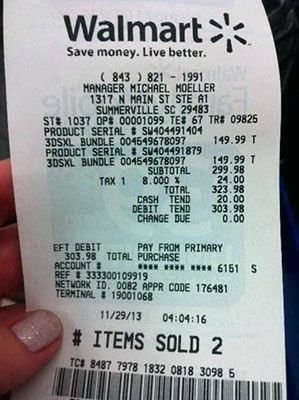

In [2]:
import requests
import IPython.display as Disp

# url_path = "https://www.dailylocal.com/wp-content/uploads/migration/2019/01/120341f55edc2c5ab19d369379cbd4ab.jpg?w=1200"
url_path = "https://i.pinimg.com/474x/03/9a/52/039a523f20716c7cc60d6e8424671fd3.jpg"
Disp.Image(requests.get(url_path).content, width=500)

In [3]:
from dotenv import load_dotenv
import os
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from IPython.display import display, Markdown


AZURE_LAYOUT_ENDPOINT="https://westus2.api.cognitive.microsoft.com/"
AZURE_LAYOUT_API_KEY="9ceb44ddb4fb4bbb8b75880978cd003b"

loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=AZURE_LAYOUT_ENDPOINT, api_key=AZURE_LAYOUT_API_KEY, url_path=url_path, api_model="prebuilt-layout"
)

documents = loader.load()

display(Markdown(documents[0].page_content))

<figure>

![](figures/0)

<!-- FigureContent="Walmart Save money. Live better." -->

</figure>


( 843 ) 821 - 1991 MANAGER MICHAEL MOELLER 1317 N MAIN ST STE A1 SUMMERVILLE SC 29483 ST# 1037 OP# 00001099 TE# 67 TR# 09825 PRODUCT SERIAL # SW404491404

3DSXL BUNDLE 004549678097 149.99 T

PRODUCT SERIAL # SU404491879

3DSXL BUNDLE 004549678097 149.99 T

SUBTOTAL

299.98

TAX 1

8.000 %

24.00

TOTAL

323.98

CASH TEND

20.00

DEBIT TEND

303.98

CHANGE DUE

0.00

EFT DEBIT

PAY FROM PRIMARY

303.98 TOTAL PURCHASE

ACCOUNT #

\*\*\*\* \*\*\*\* \*\*\*\* 6151 S

REF # 333300109919

NETWORK ID. 0082 APPR CODE 176481

TERMINAL # 19001068

11/29/13 04:04:16

\# ITEMS SOLD 2

TC# 8487 7978 1832 0818 3098 5


In [4]:
from pydantic import BaseModel, Field
from typing import Deque, List, Optional, Tuple

class ReceiptItem(BaseModel):
    TotalPrice: Optional[float] = Field(..., description="Total price of the item.")
    Description: Optional[str] = Field(..., description="Description of the item.")
    Quantity: Optional[int] = Field(..., description="Quantity of the item.")
    UnitPrice: Optional[float] = Field(..., description="Unit price of the item.")
    QuantityUnit: Optional[str] = Field(..., description="Unit of the quantity.")
    ProductCode: Optional[str] = Field(..., description="Product code of the item.")

class TaxDetail(BaseModel):
    TaxAmount: Optional[float] = Field(..., description="Total amount of tax.")
    TaxRate: Optional[float] = Field(..., description="Rate of tax.")

class ReceiptData(BaseModel):
    MerchantName: Optional[str] = Field(..., description="Name of the merchant issuing the receipt.")
    MerchantPhoneNumber: Optional[str] = Field(..., description="Listed phone number of merchant.")
    MerchantAddress: Optional[str] = Field(..., description="Listed address of the merchant.")
    Total: Optional[float] = Field(..., description="Total amount of the transaction.")
    TransactionDate: Optional[str] = Field(..., description="Date of the transaction.")
    TransactionTime: Optional[str] = Field(..., description="Time of the transaction.")
    Subtotal: Optional[float] = Field(..., description="Subtotal amount of the transaction.")
    TotalTax: Optional[float] = Field(..., description="Total tax amount of the transaction.")
    Tip: Optional[float] = Field(..., description="Tip amount of the transaction.")
    Total: Optional[float] = Field(..., description="Total amount of the transaction.")
    Items: Optional[List[ReceiptItem]] = Field(..., description="List of items on the receipt.")
    TaxDetails: Optional[List[TaxDetail]] = Field(None, description="Details of tax.")


data = {
    "description": "Receipt",
    "schema": ReceiptData.schema(),
    "instruction": (
        "Extract standard receipt data. "
    )
}

from pprint import pprint
pprint(ReceiptData.schema())

{'definitions': {'ReceiptItem': {'properties': {'Description': {'description': 'Description '
                                                                               'of '
                                                                               'the '
                                                                               'item.',
                                                                'title': 'Description',
                                                                'type': 'string'},
                                                'ProductCode': {'description': 'Product '
                                                                               'code '
                                                                               'of '
                                                                               'the '
                                                                               'item.',
                                        

In [5]:
response = requests.post(f"{url}/extractors", json=data)

extractor = response.json()
print(extractor)

{'uuid': 'fc0a8991-e483-4fe5-8d9a-b362938efb5e'}


We can now try the extractor on our PDF:

In [6]:
result = requests.post(
    f"{url}/extract",
    data={"extractor_id": extractor["uuid"], "text": documents[0].page_content, "mode": "retrieval"}
)

result

<Response [200]>

In [7]:
result.json()

{'Tip': 0,
 'Items': [{'Quantity': 1,
   'UnitPrice': 149.99,
   'TotalPrice': 149.99,
   'Description': '3DSXL BUNDLE',
   'ProductCode': '004549678097',
   'QuantityUnit': 'T'}],
 'Total': 323.98,
 'Subtotal': 299.98,
 'TotalTax': 24.0,
 'TaxDetails': [{'TaxRate': 8.0, 'TaxAmount': 24.0}],
 'MerchantName': 'Walmart',
 'MerchantAddress': '1317 N MAIN ST STE A1 SUMMERVILLE SC 29483',
 'TransactionDate': '11/29/13',
 'TransactionTime': '04:04:16',
 'MerchantPhoneNumber': '8438211991'}

We've extracted several records capturing various earnings and revenue figures, and have conformed the records to the desired schema.

We can convey additional instructions to the LLM efficiently via few-shot examples. For example, we can specify how the names of financial metrics should be normalized, or how scales (millions, billions, percentages, etc.) should be represented in different cases.

The `examples` endpoint lets us associate few-shot examples with an extractor. We can specify examples by pairing text inputs with lists of `FinancialData` outputs:

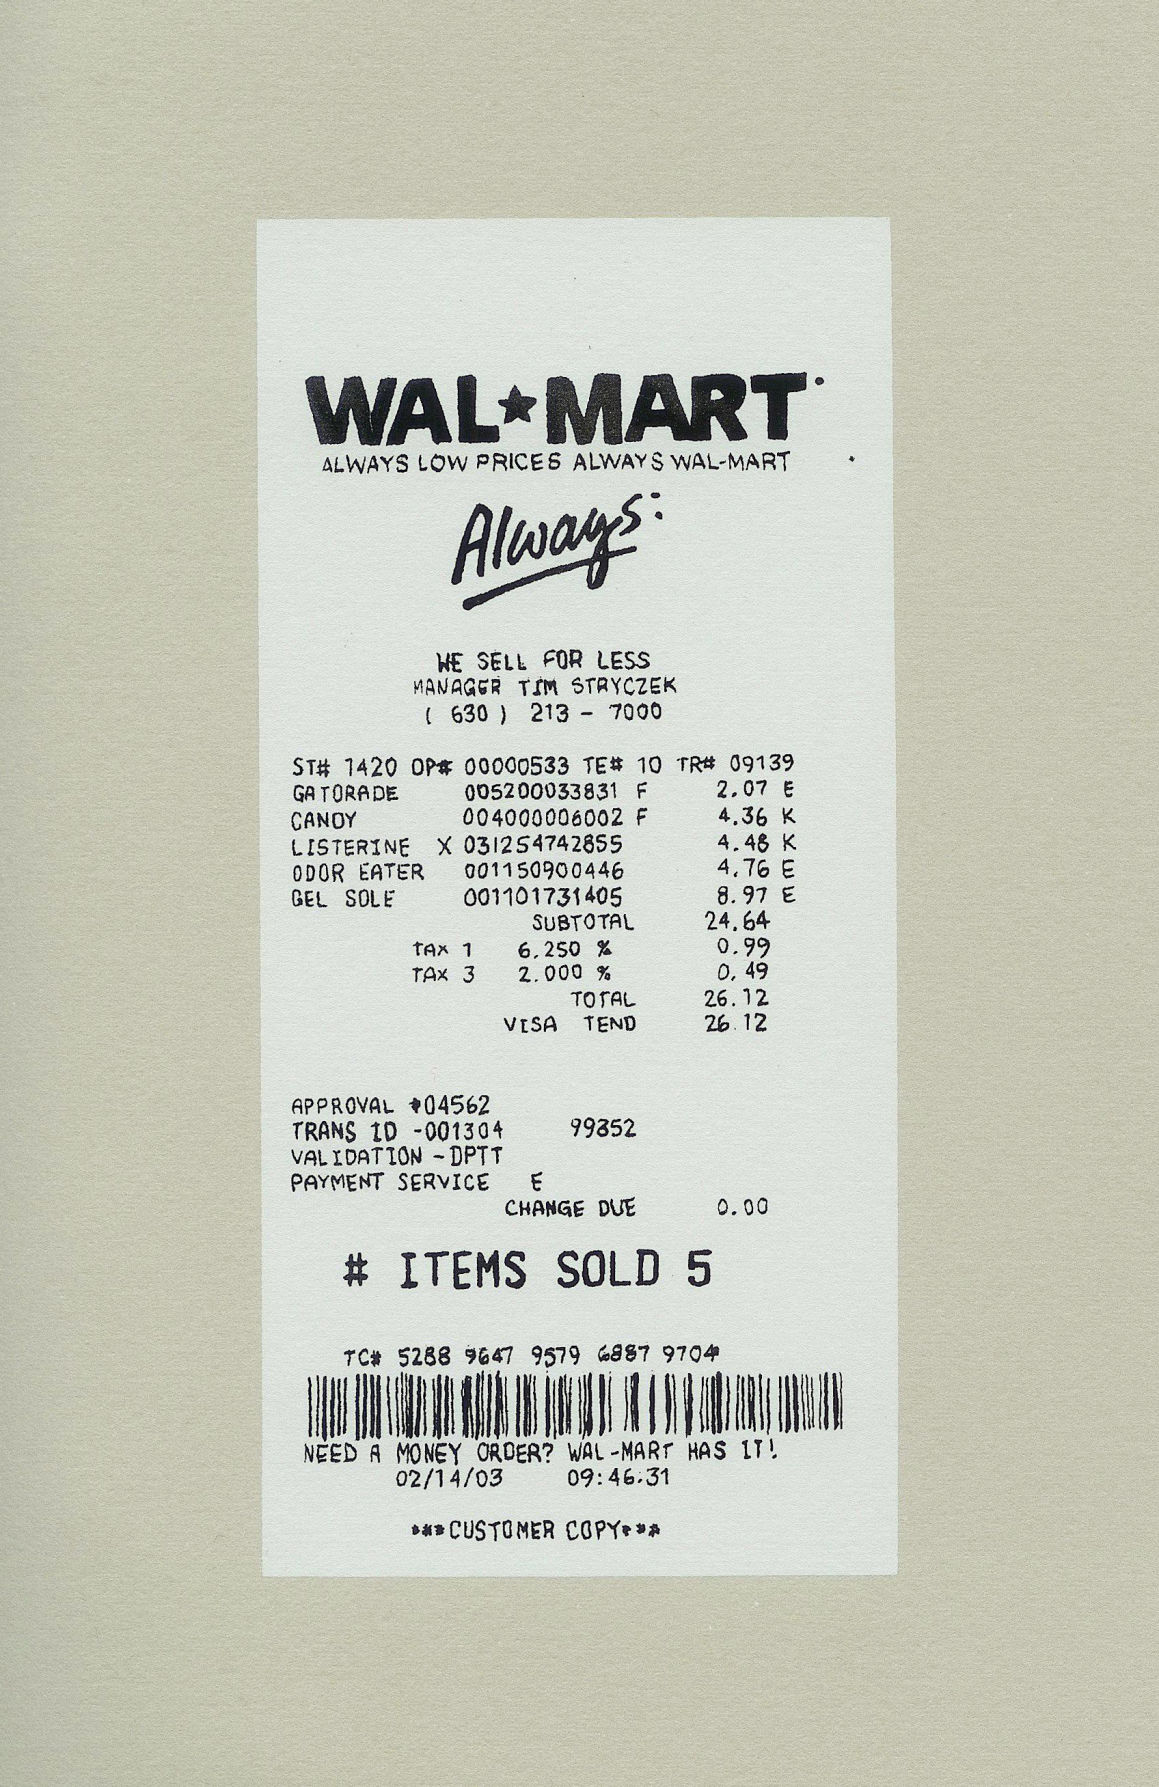

In [8]:
sample_url_path = "https://www.dailylocal.com/wp-content/uploads/migration/2019/01/120341f55edc2c5ab19d369379cbd4ab.jpg?w=1200"
Disp.Image(requests.get(sample_url_path).content, width=500)

In [9]:
sample_loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=AZURE_LAYOUT_ENDPOINT, api_key=AZURE_LAYOUT_API_KEY, url_path=sample_url_path, api_model="prebuilt-layout"
)

sample_documents = sample_loader.load()
display(Markdown(sample_documents[0].page_content))


<figure>

![](figures/0)

<!-- FigureContent="WALMART e ALWAYS LOW PRICES ALWAYS WAL-MART" -->

</figure>


<figure>

![](figures/1)

<!-- FigureContent="Always S:" -->

</figure>


WE SELL FOR LESS MANAGER TÍM STRYCZEK ( 630 ) 213 - 7000

|||||||
| - | - | - | - | - | - |
|||| ST# 1420 OP# 00000533 TE# 10 TR# 09139 |   ||
| GATORADE | || 005200033831 F  | 2.07 E ||
| CANOY | || 004000006002 F  | 4.36 K ||
| LISTERINE  :selected: || X 031254742855 | | 4.48 K ||
| ODOR EATER | :unselected: | 001150900446 | | 4,76 E ||
| GEL SOLE | | 001101731405 | | 8.97 E ||
| | | SUBTOTAL | | 24.64 ||
| TAX 1 || 6.250 % | | 0.99 ||
| | TAX 3 | 2.000 % | | 0,49 ||
| | | TOTAL | | 26.12 ||
| | | VISA TEND | | 26.12 ||
| APPROVAL +04562 || | | ||
|| TRANS ID -001304  | 99352 | | | |
|| VALIDATION - DPTT  | | | ||
| PAYMENT SERVICE || E | | ||
| | | CHANGE DUE | | 0.00 ||

\# ITEMS SOLD 5

TC# 5288 9647 9579 6887 9704

NEED A MONEY ORDER? WAL-MART HAS IT! 02/14/03 09:46:31

\*\* CUSTOMER COPY \*\*\*


In [10]:
result = requests.post(
    f"{url}/extract",
    data={"extractor_id": extractor["uuid"], "text": sample_documents[0].page_content, "mode": "retrieval"}
)

result.json()

{'Tip': 0,
 'Items': [{'Quantity': 1,
   'UnitPrice': 2.07,
   'TotalPrice': 2.07,
   'Description': 'GATORADE',
   'ProductCode': '005200033831',
   'QuantityUnit': 'F'},
  {'Quantity': 1,
   'UnitPrice': 4.36,
   'TotalPrice': 4.36,
   'Description': 'CANOY',
   'ProductCode': '004000006002',
   'QuantityUnit': 'F'},
  {'Quantity': 1,
   'UnitPrice': 4.48,
   'TotalPrice': 4.48,
   'Description': 'LISTERINE',
   'ProductCode': '031254742855',
   'QuantityUnit': 'X'},
  {'Quantity': 1,
   'UnitPrice': 4.76,
   'TotalPrice': 4.76,
   'Description': 'ODOR EATER',
   'ProductCode': '001150900446',
   'QuantityUnit': ''},
  {'Quantity': 1,
   'UnitPrice': 8.97,
   'TotalPrice': 8.97,
   'Description': 'GEL SOLE',
   'ProductCode': '001101731405',
   'QuantityUnit': ''}],
 'Total': 26.12,
 'Subtotal': 24.64,
 'TotalTax': 1.48,
 'TaxDetails': [{'TaxRate': 6.25, 'TaxAmount': 0.99},
  {'TaxRate': 2, 'TaxAmount': 0.49}],
 'MerchantName': 'WALMART',
 'MerchantAddress': 'WE SELL FOR LESS MANAGER

In [11]:
examples = [
    {
        "text": "<figure>\n\n![](figures/0)\n\n<!-- FigureContent=\"WALMART e ALWAYS LOW PRICES ALWAYS WAL-MART\" -->\n\n</figure>\n\n\n<figure>\n\n![](figures/1)\n\n<!-- FigureContent=\"Always S:\" -->\n\n</figure>\n\n\nWE SELL FOR LESS MANAGER TÍM STRYCZEK ( 630 ) 213 - 7000\n\n|||||||\n| - | - | - | - | - | - |\n|||| ST# 1420 OP# 00000533 TE# 10 TR# 09139 |   ||\n| GATORADE | || 005200033831 F  | 2.07 E ||\n| CANOY | || 004000006002 F  | 4.36 K ||\n| LISTERINE  :selected: || X 031254742855 | | 4.48 K ||\n| ODOR EATER | :unselected: | 001150900446 | | 4,76 E ||\n| GEL SOLE | | 001101731405 | | 8.97 E ||\n| | | SUBTOTAL | | 24.64 ||\n| TAX 1 || 6.250 % | | 0.99 ||\n| | TAX 3 | 2.000 % | | 0,49 ||\n| | | TOTAL | | 26.12 ||\n| | | VISA TEND | | 26.12 ||\n| APPROVAL +04562 || | | ||\n|| TRANS ID -001304  | 99352 | | | |\n|| VALIDATION - DPTT  | | | ||\n| PAYMENT SERVICE || E | | ||\n| | | CHANGE DUE | | 0.00 ||\n\n\\# ITEMS SOLD 5\n\nTC# 5288 9647 9579 6887 9704\n\nNEED A MONEY ORDER? WAL-MART HAS IT! 02/14/03 09:46:31\n\n\\*\\* CUSTOMER COPY \\*\\*\\*",
        "output": {
            'Tip': 0,
            'Items': [{'Quantity': 1,
                'UnitPrice': 2.07,
                'TotalPrice': 2.07,
                'Description': 'GATORADE',
                'ProductCode': '005200033831',
                'QuantityUnit': ''},
                {'Quantity': 1,
                'UnitPrice': 4.36,
                'TotalPrice': 4.36,
                'Description': 'CANOY',
                'ProductCode': '004000006002',
                'QuantityUnit': ''},
                {'Quantity': 1,
                'UnitPrice': 4.48,
                'TotalPrice': 4.48,
                'Description': 'LISTERINE',
                'ProductCode': '031254742855',
                'QuantityUnit': ''},
                {'Quantity': 1,
                'UnitPrice': 4.76,
                'TotalPrice': 4.76,
                'Description': 'ODOR EATER',
                'ProductCode': '001150900446',
                'QuantityUnit': ''},
                {'Quantity': 1,
                'UnitPrice': 8.97,
                'TotalPrice': 8.97,
                'Description': 'GEL SOLE',
                'ProductCode': '001101731405',
                'QuantityUnit': ''}],
            'Total': 26.12,
            'Subtotal': 24.64,
            'TaxDetails': [{'TaxRate': 6.25, 'TaxAmount': 0.99},
                {'TaxRate': 2, 'TaxAmount': 0.49}],
            'MerchantName': 'WALMART',
            'MerchantAddress': '',
            'TransactionDate': '02/14/03',
            'TransactionTime': '09:46:31',
            'MerchantPhoneNumber': '( 630 ) 213 - 7000'
        },
    },
]

responses = []
for example in examples:
    create_request = {
        "extractor_id": extractor["uuid"],
        "content": example["text"],
        "output": example['output'],
    }
    response = requests.post(f"{url}/examples", json=create_request)
    responses.append(response)

responses

[<Response [200]>]

Having posted the examples, we can re-run the extraction:

In [12]:
result = requests.post(
    f"{url}/extract",
    data={"extractor_id": extractor["uuid"], "text": documents[0].page_content, "mode": "retrieval"}
)

result

<Response [200]>

In [13]:
result.json()

{'Tip': 0,
 'Items': [{'Quantity': 1,
   'UnitPrice': 149.99,
   'TotalPrice': 149.99,
   'Description': '3DSXL BUNDLE',
   'ProductCode': '004549678097',
   'QuantityUnit': ''},
  {'Quantity': 1,
   'UnitPrice': 149.99,
   'TotalPrice': 149.99,
   'Description': '3DSXL BUNDLE',
   'ProductCode': '004549678097',
   'QuantityUnit': ''}],
 'Total': 323.98,
 'Subtotal': 299.98,
 'TotalTax': 24.0,
 'TaxDetails': [{'TaxRate': 8, 'TaxAmount': 24.0}],
 'MerchantName': 'Walmart',
 'MerchantAddress': '1317 N MAIN ST STE A1 SUMMERVILLE SC 29483',
 'TransactionDate': '11/29/13',
 'TransactionTime': '04:04:16',
 'MerchantPhoneNumber': '( 843 ) 821 - 1991'}